In [1]:
import quanguru as qg
import numpy as np
import matplotlib.pyplot as plt
import platform

# 17 - Jaynes-Cummings Dynamics

The Jaynes-Cummings Hamiltonian is written as

$H_{JC} = \hbar\omega_{c} a^{\dagger}a + \frac{1}{2}\hbar\omega_{q}\sigma_{z} + \hbar g(a^{\dagger}\sigma_{-} + a\sigma_{+})$

where $\sigma_{\pm} = (\sigma_{x} \pm i\sigma_{y})/2$ are raising/lowering operators for a two-level system, $\sigma_{\mu}$ are the Pauli spin operators with $\mu\in\{x,y,z\}$, $a^{\dagger}$ and $a$ are the creation and annihilation operators for the field mode, and $\omega_{c}$, $\omega_{q}$, and $g$ are the cavity-field, qubit, and coupling (angular-) frequencies, respectively.

We will use the below parameters in our simulation

In [2]:
# parameters for the Hamiltonian
qubitFreq = 1
cavityFreq = 1
couplingFreq = 0.25
cavityDim = 5

# parameters for the evolution
totalTime = 3*(np.pi/couplingFreq)
timeStep = 0.1

and we can describe the JC-Hamiltonian/system in QuanGuru as

In [3]:
# Qubit for the JC model
QubitJC = qg.Qubit(frequency=qubitFreq)

# Cavity for the JC model
CavityJC = qg.Cavity(dimension=cavityDim, frequency=cavityFreq)

# JC model consists of a qubit and cavity
# and this is the 'free evolution' part of the JC-Hamiltonian
JCSystem = QubitJC + CavityJC

In [4]:
# coupling part of the JC-Hamiltonian
# first term of the coupling
JCCouplingT1 = JCSystem.createTerm(
    qSystem=[CavityJC, QubitJC],
    operator=[qg.destroy, qg.sigmap])

# second term of the couplings
# first term of the coupling
JCCouplingT2 = JCSystem.createTerm(
    qSystem=[QubitJC, CavityJC],
    operator=[qg.sigmam, qg.create])

# combine the terms into a single term
JCCoupling = qg.QTerm(qSystem=JCSystem,
                      subSys=[JCCouplingT1, JCCouplingT2],
                      frequency=couplingFreq)

In [5]:
JCSystem.simStepSize = timeStep
JCSystem.simTotalTime = totalTime

JCSystem.initialState = [1, 1]

freqSweep = JCSystem.simulation.Sweep.createSweep(
    system=CavityJC,
    sweepKey="frequency",
    sweepMax=qubitFreq+cavityFreq,
    sweepMin=qubitFreq-cavityFreq,
    sweepStep=.025)

In [6]:
compositeSZ = qg.compositeOp(qg.sigmaz(),   dimA=cavityDim)

# calculate the desired results and store
def compute(sim, args):
    stateJC = args[0]
    sim.results['zJC'].append(qg.expectation(compositeSZ, stateJC))

JCSystem.simCompute = compute

<span style="color:red" font-weight="bold"> IMPORTANT NOTE FOR WINDOWS USERS : MULTI-PROCESSING (p=True) DOES NOT WORK WITH NOTEBOOK

You can use a python script, but you will need to make sure that the critical parts of the code are under ``` if __name__ == "__main__": ``` We are going to add further tutorials for this later.

In [7]:
# do not store the states
JCSystem.simDelStates = True

# run the simulation
# p=True uses multi-processing for the sweep
JCSystem.runSimulation(p=(platform.system() != 'Windows'))

[]

Text(0, 0.5, 'Time')

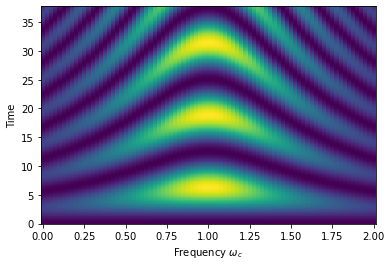

In [8]:
Y, X = np.meshgrid(JCSystem.simulation.timeList, freqSweep.sweepList)

plt.pcolormesh(X, Y, JCSystem.simulation.results['zJC'])

plt.xlabel("Frequency $\omega_{c}$")
plt.ylabel("Time")